# Energy Data Science - Homework #1
Kacper Aleksander 244693EV

Tallinn University of Technology

26th of October, 2024

# Introduction
I will analyse energy production data collected from some PV panel close to Tallinn. Such data is important to get a deeper understanding of supply of solar energy. By looking for patterns, and correlations with other variables, we can predict solar generation in the future. From my point of view, this might be some very useful information for the Demand Response system, in which consumers of energy match their demand with current energy supply.

# Data collection

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df.drop('timestamp', axis=1, inplace=True)
df.set_index('datetime', inplace=True)
df

,raw,temperature,modified1,modified2,modified3
datetime,,,,,
2021-02-02 00:00:00,0.0,-3.9,0.0,0.0,0.0
2021-02-02 01:00:00,0.0,-3.5,0.0,0.0,0.0
2021-02-02 02:00:00,0.0,-3.0,0.0,0.0,0.0
2021-02-02 03:00:00,0.0,-2.6,0.0,0.0,0.0
2021-02-02 04:00:00,0.0,-2.4,0.0,0.0,0.0
...,...,...,...,...,...
2023-02-01 19:00:00,0.0,0.0,0.0,0.0,0.0
2023-02-01 20:00:00,0.0,0.1,0.0,0.0,0.0
2023-02-01 21:00:00,0.0,0.1,0.0,0.0,0.0


I have hourly energy production data with the following features: raw, temperature, modified1, modified2, modified3. I might consider adding some other weather features from some external source, for example cloudiness, which intuitively seems important for solar panels. For now, I will focus on what I have.

# Data cleaning
## Reading the data
Let's check if there are missing values.

In [3]:
df.isnull().sum()

raw               0
temperature       0
modified1      1191
modified2      1375
modified3      1137
dtype: int64

As we can see, there is missing data in modified columns. Let's check how the variables compare against each other, and what does their distribution look like.

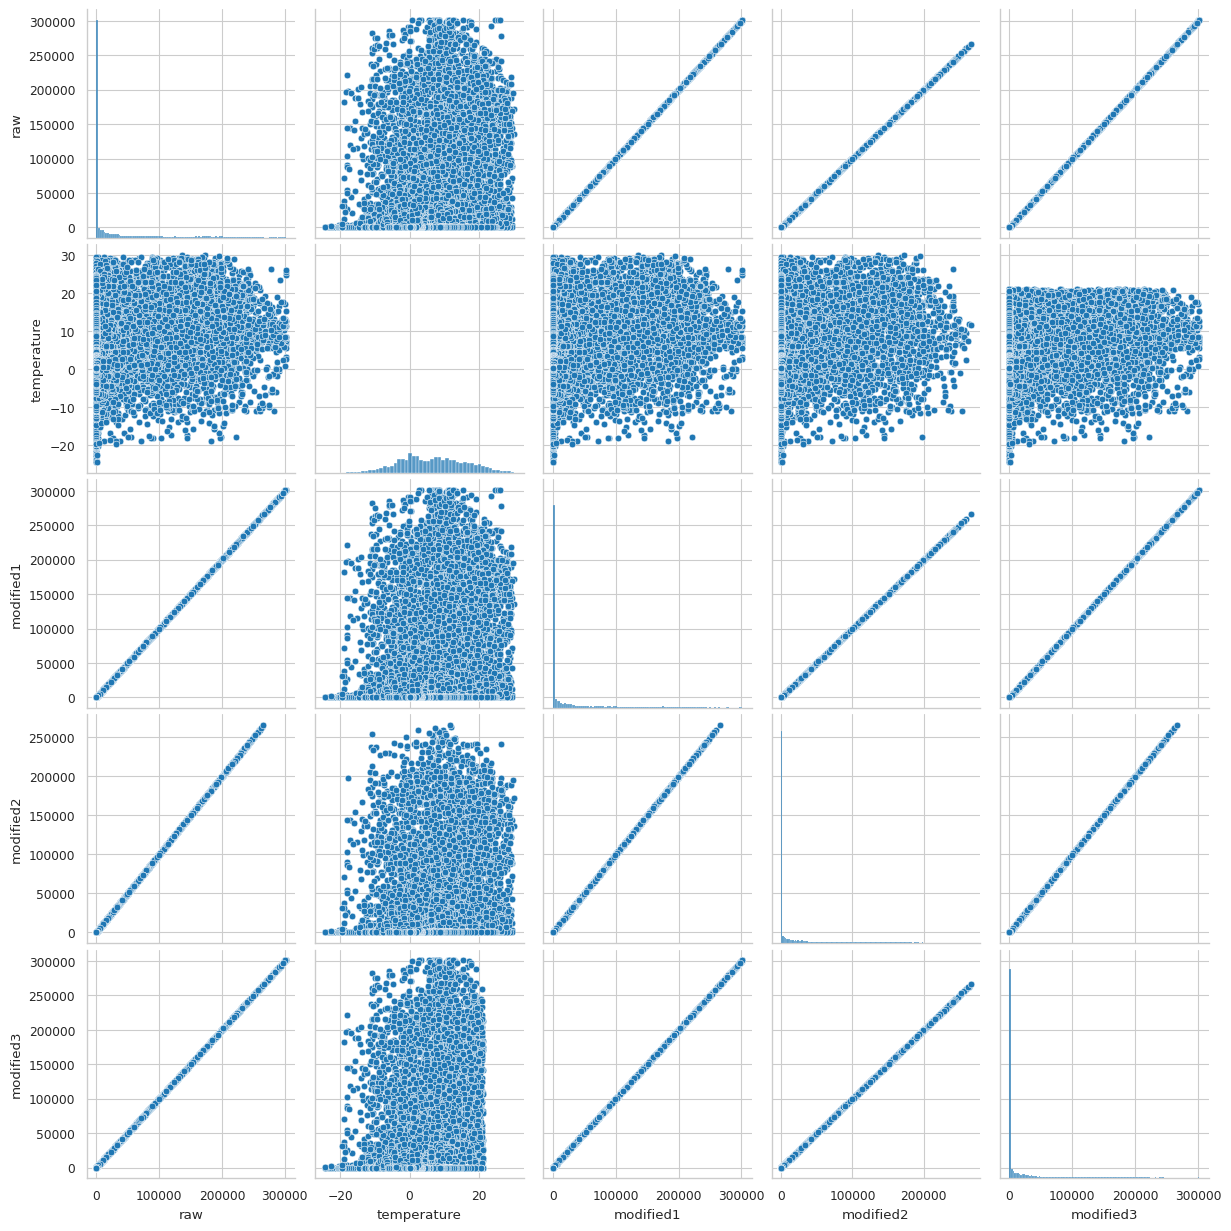

In [4]:
sns.set_style('whitegrid')
sns.set_context('paper')

sns.pairplot(df)
plt.savefig('charts/pairplot')
plt.show()


What caught my attention first, is that it looks like the correlation between raw and the modified features is 1. Also, there seems to be a problem with modified3 values over a certain temperature. Let's verify the first assumption.

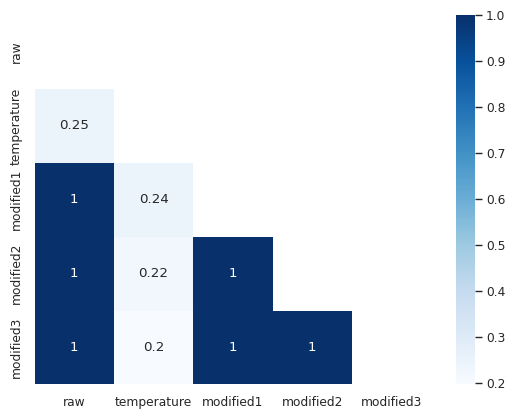

In [5]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_style('white')

sns.heatmap(corr, mask=mask, annot=True, cmap='Blues')
plt.savefig('charts/correlation-matrix')
plt.show()

This means that wherever a modified value is not missing, it is always the same as the raw temperature data. In real life, this might mean that there were 3 data-collecting sensors (corresponding to modified1, modified2, and modified3), and that the raw value comes directly from these sensors. So that whenever there was missing data from some sensor, it could be taken from some other sensor that made the measurement.

Based on this knowledge, I will get rid of modified1, modified2 and modified3 features in the next sections, as they essentialy are incomplete duplicates of raw data. Before I do this, I will handle missing data in the variable modified1 only for puposes of this report.

Let's see in detail if missing data might be connected to recorded temperature.

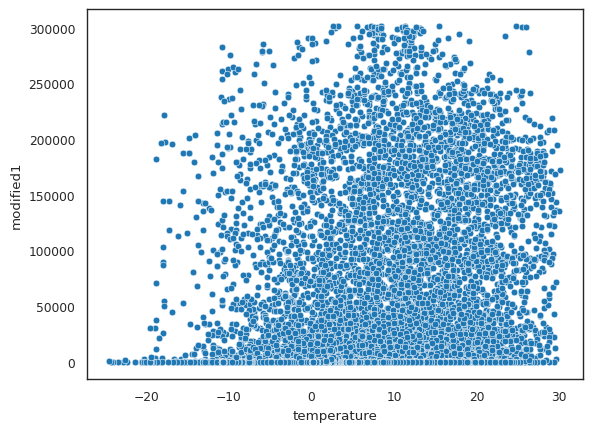

In [6]:
sns.scatterplot(df, x='temperature', y='modified1')
plt.savefig('charts/modified1-scatterplot')
plt.show()

Looks like modified1 values are missing completely at random (MCAR), as there is no clear pattern visible with my current knowledge.

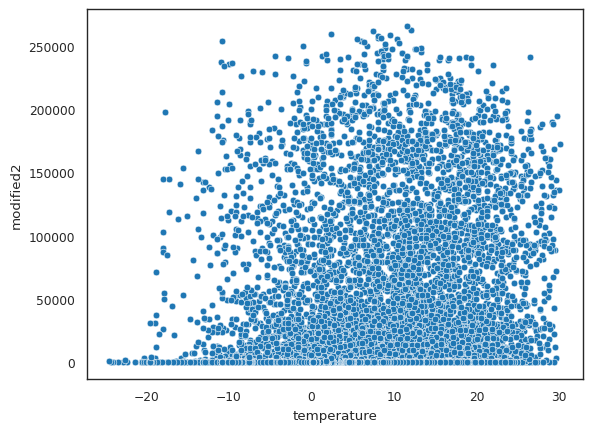

In [7]:
sns.scatterplot(df, x='temperature', y='modified2')
plt.savefig('charts/modified2-scatterplot')
plt.show()

It seems to be the same case for modified2 - missing completely at random (MCAR). 

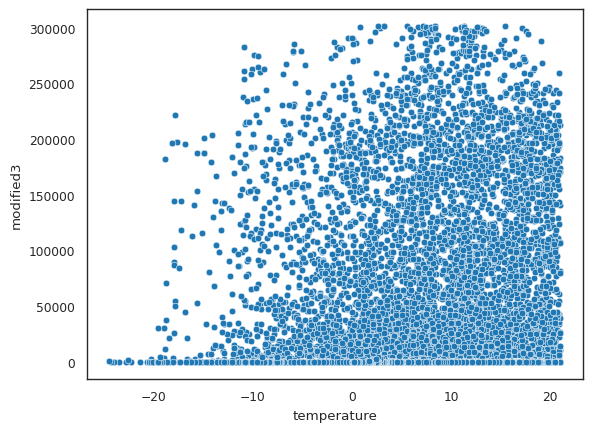

In [8]:
sns.scatterplot(df, x='temperature', y='modified3')
plt.savefig('charts/modified3-scatterplot')
plt.show()

It is clear that when it comes to modified3, there is some maximum temperature that sets the limit for recording data over that temperature. Because temperature is an external factor to energy production, those values are classified as missing at random (MAR).


In [9]:
mod3 = df[df['modified3'].notnull()]
mod3.temperature.max()

21.0

This temperature seems to be 21°C. If modified3 resembles recordings of a single sensor indeed, then it might suggest that 21°C is the upper limit of this sensor, whether it's because of its specifications or some problems.

## Cleaning the data; Dealing with missing values in modified1

In [10]:
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.impute import KNNImputer

### Deletion

In [11]:
mod1_deletion = df[df.modified1.notnull()]

mod1_deletion.isnull().sum()

raw               0
temperature       0
modified1         0
modified2      1277
modified3      1030
dtype: int64

In [12]:
# MAPE and RMSE performance metrics work only on series with the same lengths.

stderr_deletion = np.std([np.std(df.raw), np.std(mod1_deletion.modified1)])
print(f'Standard error: {stderr_deletion:.2f}')

Standard error: 129.70


### Univariate imputation

In [13]:
print(np.median(df.raw))

0.0


In [14]:
mod1_univariate = df.fillna(value={'modified1': 0})
mod1_univariate.isnull().sum()

raw               0
temperature       0
modified1         0
modified2      1375
modified3      1137
dtype: int64

In [15]:
mape_univariate = mean_absolute_percentage_error(df.raw, mod1_univariate.modified1)
print(f'Mean absolute percentage error: {mape_univariate*100:.3f}%')

rmse_univariate = root_mean_squared_error(df.raw, mod1_univariate.modified1)
print(f'Root mean squared error: {rmse_univariate:.0f}')

stderr_univariate = np.std([np.std(df.raw), np.std(mod1_univariate.modified1)])
print(f'Standard error: {stderr_univariate:.2f}')

Mean absolute percentage error: 3.315%
Root mean squared error: 21323
Standard error: 977.60


### Multivariate imputation

In [16]:
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(df[['raw', 'modified1']])
mod1_multivariate = pd.DataFrame(imputed)
mod1_multivariate.rename(columns={0: 'raw', 1: 'modified1'}, inplace=True)
mod1_multivariate.set_index(df.index, inplace=True)
mod1_multivariate.isnull().sum()

raw          0
modified1    0
dtype: int64

In [17]:
mape_multivariate = mean_absolute_percentage_error(df.raw, mod1_multivariate.modified1)
print(f'Mean absolute percentage error: {mape_multivariate*100:.3f}%')

rmse_multivariate = root_mean_squared_error(df.raw, mod1_multivariate.modified1)
print(f'Root mean squared error: {rmse_multivariate:.0f}')

stderr_multivariate = np.std([np.std(df.raw), np.std(mod1_multivariate.modified1)])
print(f'Standard error: {stderr_multivariate:.2f}')

Mean absolute percentage error: 0.005%
Root mean squared error: 10
Standard error: 0.12


Based on the chosen metrics, multivariate imputation seems to be highly effective in our case.

In [18]:
df.drop(['modified1', 'modified2', 'modified3'], axis=1, inplace=True)

# Data exploration and Feature engineering

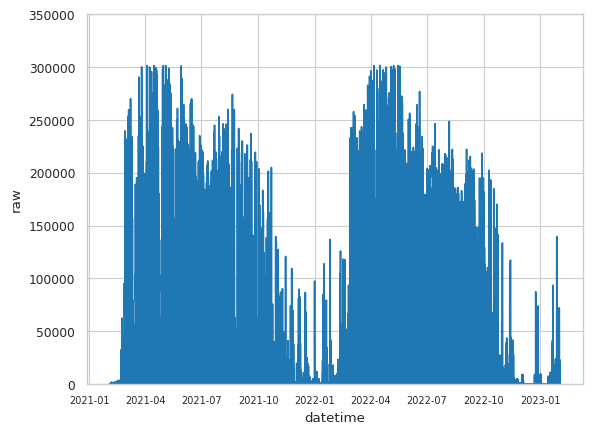

In [19]:
sns.set_style('whitegrid')
plt.ylim(bottom=0, top=350000)
sns.lineplot(df, x='datetime', y='raw')
plt.xticks(fontsize=7)
plt.savefig('charts/raw-timeseries')
plt.show()

Energy production data is seasonal.

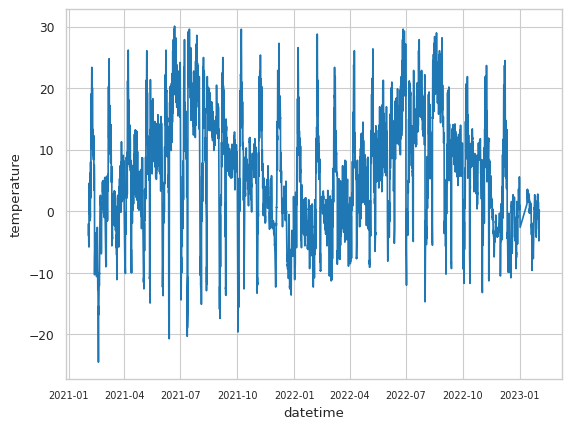

In [20]:
sns.lineplot(df, x='datetime', y='temperature')
plt.xticks(fontsize=7)
plt.savefig('charts/temperature-timeseries')
plt.show()

Temperature data is also seasonal. There are some unexpected, cyclic spikes. It requires more attention.

Let's add features that will help us catch some patterns around time.

In [21]:
df['day'] = df.index.day
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek+1
df['hour'] = df.index.hour

def is_weekend(day):
    if day > 5:
        return True
    return False

df['is_weekend'] = df.apply(lambda x: is_weekend(x.dayofweek), axis=1)

## Temperature data exploration

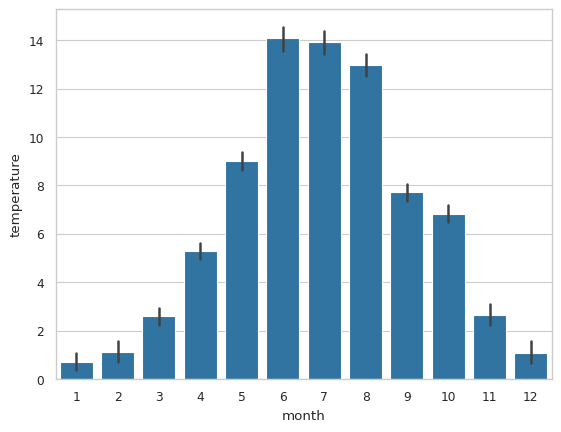

In [22]:
sns.barplot(df, y='temperature', x='month')
plt.show()

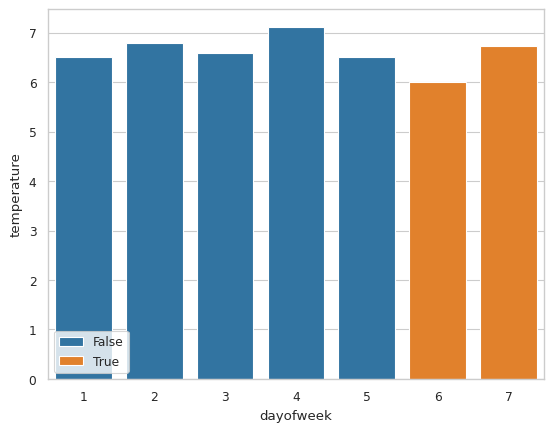

In [23]:
sns.barplot(df, y='temperature', x='dayofweek', hue='is_weekend', errorbar=None)
plt.legend(loc='lower left')
plt.show()

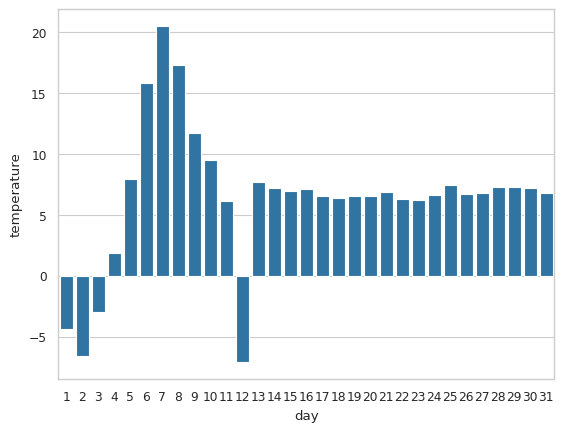

In [24]:
sns.barplot(df, y='temperature', x='day', errorbar=None)
plt.savefig('charts/temperature-day-before')
plt.show()

It is clearly visible that there is some problem with temperature data in days 1 to 12 of each month. This might explain the spikes that were visible on one of the previous charts.

Let's fix this.

In [25]:
df['temperature_fixed'] = df.temperature
temp_day_mean = {}

for day in np.arange(df.day.min(), df.day.max()+1):
    temp_day_mean[day] = np.mean(df[df.day==day].temperature)

correct_temp_day_mean = np.mean(df[df.day>12].temperature)

temp_day_mean_error = {}
for day in temp_day_mean:
    temp_day_mean_error[day] = temp_day_mean.get(day) - correct_temp_day_mean

for index in df.index:
    df.at[index, 'temperature_fixed'] = np.round(df.at[index, 'temperature'] - temp_day_mean_error.get(df.at[index, 'day']), decimals=1)

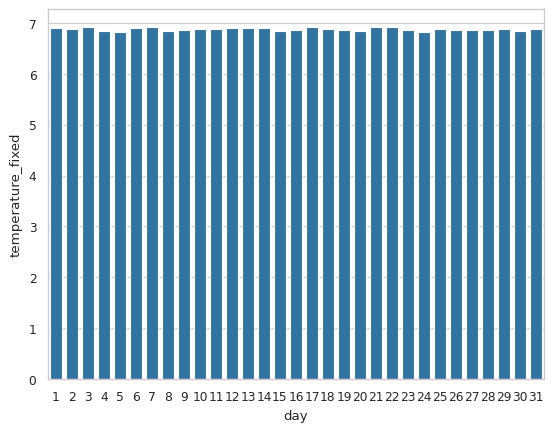

In [26]:
sns.barplot(df, y='temperature_fixed', x='day', errorbar=None)
plt.savefig('charts/temperature-day-after')
plt.show()

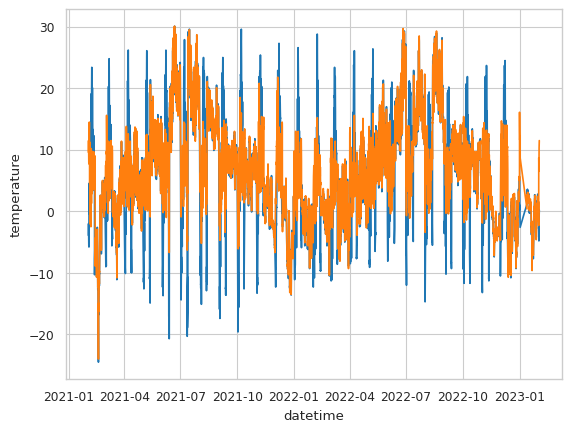

In [27]:
sns.lineplot(df, x='datetime', y='temperature', alpha=1)
sns.lineplot(df, x='datetime', y='temperature_fixed', alpha=1)
plt.show()

It looks like a slight improvement. I am not sure if such transformation was reasonable, if Dr Matson reads this, please let me know :)

Skew: 0.06404424012684107


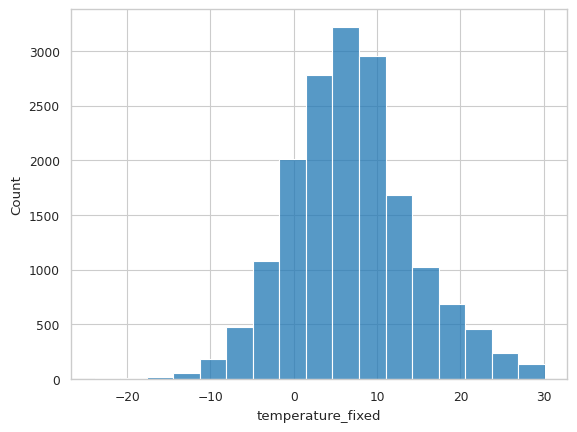

In [28]:
sns.histplot(df, x='temperature_fixed', bins=17)
print(f'Skew: {df.temperature.skew()}')

plt.savefig('charts/temperature-histogram-original')

plt.show()

Temperature data looks a lot like the bell curve, it needs only standardization.

## Energy production data exploration

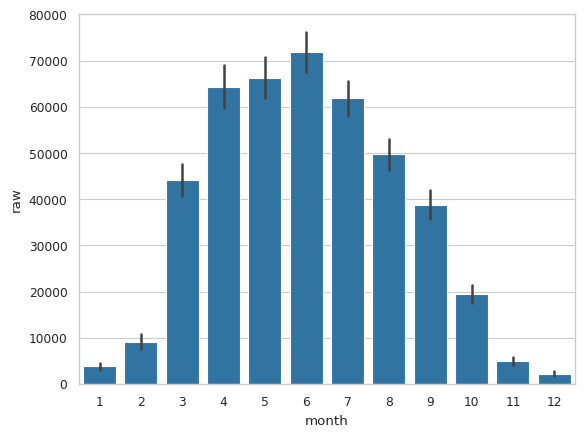

In [29]:
sns.barplot(df, y='raw', x='month')
plt.show()

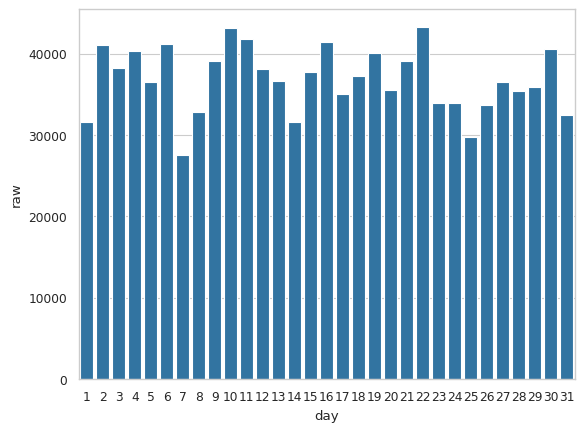

In [30]:
sns.barplot(df, y='raw', x='day', errorbar=None)
plt.show()

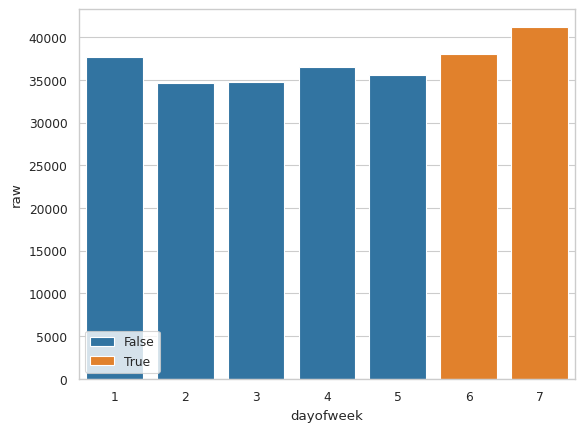

In [31]:
sns.barplot(df, y='raw', x='dayofweek', hue='is_weekend', errorbar=None)
plt.legend(loc='lower left')
plt.show()

Skew: 1.9420059688889524


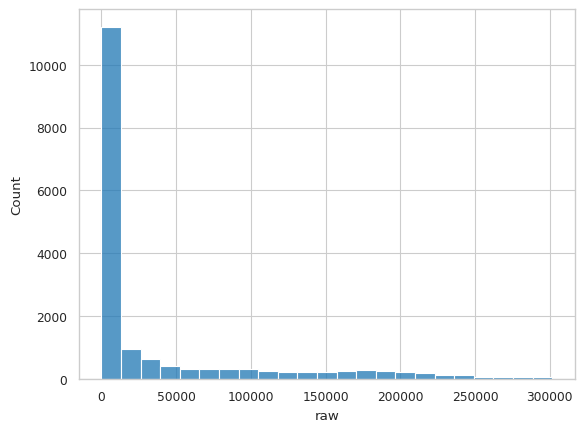

In [32]:
sns.histplot(df, x='raw', bins=23)
print(f'Skew: {df.raw.skew()}')

plt.savefig('charts/raw-histogram-original')

plt.show()

Data is right skewed, because of the fact that a lot of records have the value of 0 energy production.

## Normalization

Skew: 1.1898175665669721


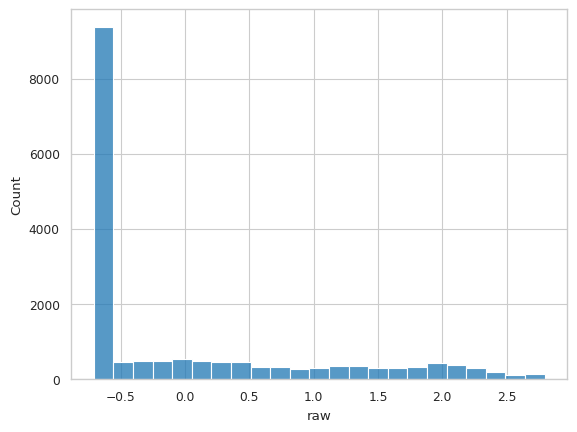

In [33]:
dfn = df.copy()

dfn.raw = df.raw ** (1/2)
dfn.raw = (dfn.raw - np.mean(dfn.raw)) / np.std(dfn.raw)
print(f'Skew: {dfn.raw.skew()}')

sns.histplot(dfn, x='raw', bins=23)
plt.savefig('charts/raw-histogram-normalized')
plt.show()

Skew: 0.28082133997334624


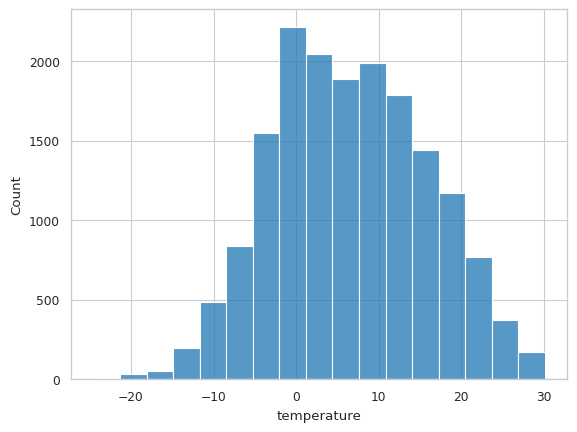

In [34]:
dfn.temperature_fixed = (df.temperature_fixed - np.mean(df.temperature_fixed)) / np.std(df.temperature_fixed)
print(f'Skew: {dfn.temperature_fixed.skew()}')

sns.histplot(dfn, x='temperature', bins=17)
plt.savefig('charts/temperature-histogram-normalized')
plt.show()

In [35]:
dfn.head()

,raw,temperature,day,month,dayofweek,hour,is_weekend,temperature_fixed
datetime,,,,,,,,
2021-02-02 00:00:00,-0.710005,-3.9,2,2,2,0,False,0.369143
2021-02-02 01:00:00,-0.710005,-3.5,2,2,2,1,False,0.423398
2021-02-02 02:00:00,-0.710005,-3.0,2,2,2,2,False,0.491216
2021-02-02 03:00:00,-0.710005,-2.6,2,2,2,3,False,0.545471
2021-02-02 04:00:00,-0.710005,-2.4,2,2,2,4,False,0.572599


# Analysis

## Additive classical decomposition

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = dfn
df.temperature = df.temperature_fixed
df.drop('temperature_fixed', axis=1, inplace=True)
df

,raw,temperature,day,month,dayofweek,hour,is_weekend
datetime,,,,,,,
2021-02-02 00:00:00,-0.710005,0.369143,2,2,2,0,False
2021-02-02 01:00:00,-0.710005,0.423398,2,2,2,1,False
2021-02-02 02:00:00,-0.710005,0.491216,2,2,2,2,False
2021-02-02 03:00:00,-0.710005,0.545471,2,2,2,3,False
2021-02-02 04:00:00,-0.710005,0.572599,2,2,2,4,False
...,...,...,...,...,...,...,...
2023-02-01 19:00:00,-0.710005,0.599726,1,2,3,19,False
2023-02-01 20:00:00,-0.710005,0.613290,1,2,3,20,False
2023-02-01 21:00:00,-0.710005,0.613290,1,2,3,21,False


In [37]:
ma_365 = df.raw.rolling(24*365, center=True).mean().to_frame()
ma_365.rename(columns={'raw':'ma_365'}, inplace=True)
df = df.join(ma_365)

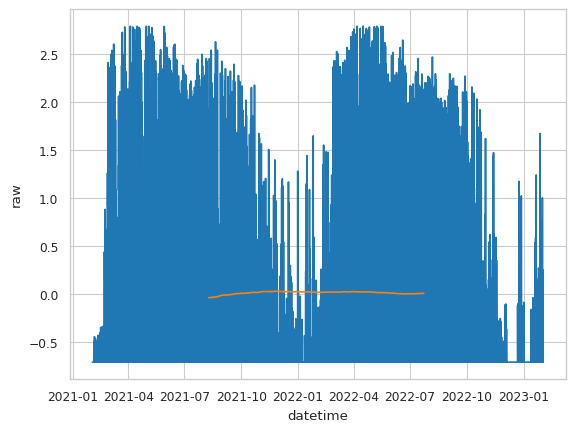

In [38]:
sns.lineplot(df, x='datetime', y='raw')
sns.lineplot(df, x='datetime', y='ma_365')

plt.savefig('charts/decomp_1')

plt.show()

In [39]:
df['seasonality_24_365'] = df.raw - df.ma_365

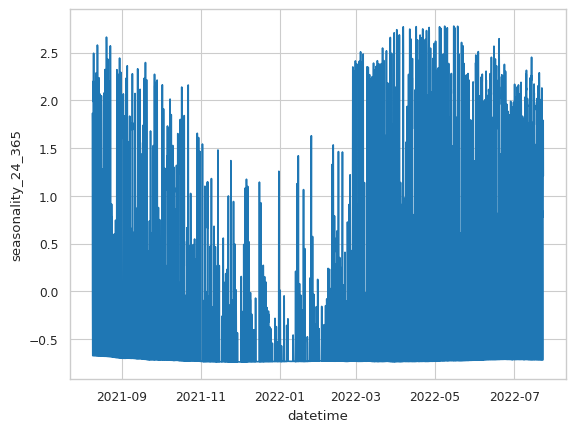

In [40]:
sns.lineplot(df, x='datetime', y='seasonality_24_365')

plt.savefig('charts/decomp_2')

plt.show()

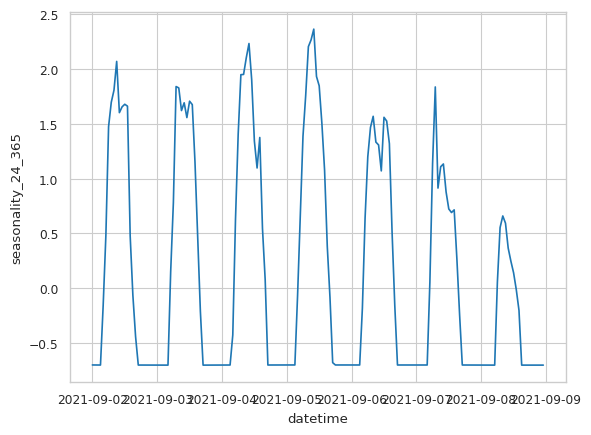

In [41]:
sns.lineplot(df['2021-09-01':'2021-09-08'], x='datetime', y='seasonality_24_365')

plt.savefig('charts/decomp_3')

plt.show()

What we have now is yearly and daily seasonality. Now let's get just the daily seasonality.

In [42]:
ma_24 = df.seasonality_24_365.rolling(24, center=True).mean().to_frame()
ma_24.rename(columns={'seasonality_24_365':'ma_24'}, inplace=True)
df = df.join(ma_24)

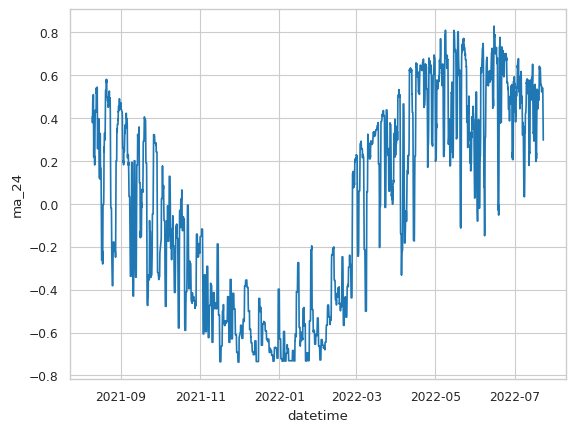

In [43]:
sns.lineplot(df, x='datetime', y='ma_24')

plt.savefig('charts/decomp_4')

plt.show()

In [44]:
df['seasonality_24'] = df.seasonality_24_365 - df.ma_24

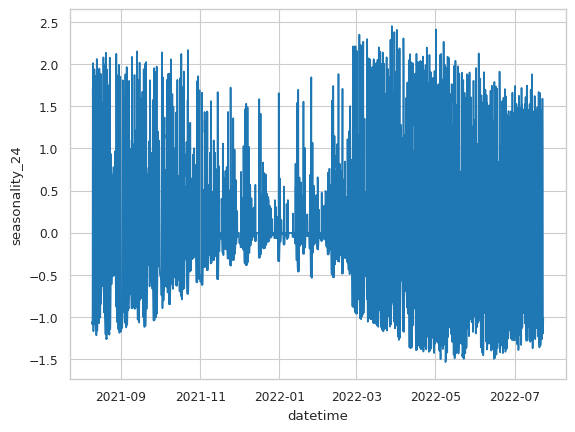

In [45]:
sns.lineplot(df, x='datetime', y='seasonality_24')

plt.savefig('charts/decomp_5')

plt.show()

In [46]:
df['seasonality_365'] = df.ma_24

24h seasonality looks like it still has 365 day seasonality aspects. I suppose it could be fixed next time by performing multiplicative classical decomposition, instead of the additive one.

I haven't performed further, to be honest I got stuck on this one. I didn't know how to approach this data where there were 2 seasonalities (yearly and daily) and how exactly am I supposed to count averages for certain periods during the day/year to get rid of the noise. I know that there is the pd.Grouper with its frequency, but in this dataset there were some missing indices (more that 1h gap between records) and I wasn't sure if this is going to mess things up even further. I'm looking for feedback!